In [1]:
#python import statements

import numpy as np
import matplotlib.pyplot as plt
import cmath
import math
import itertools

In [2]:
#qiskit import statements

from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.quantum_info import random_statevector, Statevector
import qiskit.quantum_info as qi
from qiskit.circuit import Parameter #allows us to have parameterized gates
from qiskit.extensions import UnitaryGate

# Use Aer's qasm_simulator
simulator = AerSimulator()

In [3]:
#define the parameters that we want to work with 
#phi_1, phi_2, = Parameter('phi_1'), Parameter('phi_2')

#manually setting the other projector parameters 
#phi_1 = 0
#phi_2 = 0
#theta_1 = 0.5*math.pi
#theta_2 = 0.5*math.pi

In [41]:

def add_beamsplitter(top_index, angle, cr):
    cr.cz(top_index, top_index+1) 
    cr.cx(top_index, top_index+1)
    cr.cry(angle, top_index+1, top_index)
    cr.cx(top_index, top_index+1)
    cr.cz(top_index, top_index+1)

def add_proj_bot(top_index, ancilla, cr):
    cr.cz(top_index, top_index+1)
    cr.cx(top_index, top_index+1)
    cr.cx(top_index+1, top_index)
    cr.cz(top_index+1, top_index)
    cr.crx(math.pi, top_index, top_index+1)
    cr.cx(top_index, ancilla)
    cr.cx(top_index+1, ancilla+1)
    cr.crx(math.pi, top_index, top_index+1)
    cr.cz(top_index+1, top_index)
    cr.cx(top_index+1, top_index)
    cr.cx(top_index, top_index+1)
    cr.cz(top_index, top_index+1)

def add_proj_top(top_index, ancilla, cr): 
    cr.cz(top_index+1, top_index)
    cr.cx(top_index+1, top_index)
    cr.cx(top_index, top_index+1)
    cr.cz(top_index, top_index+1)
    cr.crx(math.pi, top_index+1, top_index)
    cr.cx(top_index, ancilla)
    cr.cx(top_index+1, ancilla+1)
    cr.crx(math.pi, top_index+1, top_index)
    cr.cz(top_index, top_index+1)
    cr.cx(top_index, top_index+1)
    cr.cx(top_index+1, top_index)
    cr.cz(top_index+1, top_index)


In [88]:
# Create the ansatz circuit
circuit = QuantumCircuit(8) #need 2N qubits in order to calculate the cost function at the end - 2 time steps and then 2 for a single interferometer

circuit.x([1, 5]) #set up initial state, single photon in one waveguide
#add_beamsplitter(0, -2*math.pi/3, circuit) #first beam splitter
#add_beamsplitter(4, -2*math.pi/3, circuit) 
add_proj_bot(0, 2, circuit) #projector to test if photon has moved to second waveguide
add_proj_bot(4, 6, circuit)
#circuit.p(0.6, 0) #add phase shift to one waveguide
#circuit.p(0.6, 4)
#add_beamsplitter(0, -1*math.pi/3, circuit) #second beam splitter
#add_beamsplitter(4, -1*math.pi/3, circuit)
#add_proj_bot(0, 2, circuit) #second projector to test if photon is still in second waveguide
#add_proj_bot(4, 6, circuit)


circuit.draw()

┌───┐                                  ┌───┐        
q_0: ──────■───■──┤ X ├─■─────■──────■───────────■─────■─┤ X ├──■───■─
     ┌───┐ │ ┌─┴─┐└─┬─┘ │ ┌───┴───┐  │       ┌───┴───┐ │ └─┬─┘┌─┴─┐ │ 
q_1: ┤ X ├─■─┤ X ├──■───■─┤ Rx(π) ├──┼────■──┤ Rx(π) ├─■───■──┤ X ├─■─
     └───┘   └───┘        └───────┘┌─┴─┐  │  └───────┘        └───┘   
q_2: ──────────────────────────────┤ X ├──┼───────────────────────────
                                   └───┘┌─┴─┐                         
q_3: ───────────────────────────────────┤ X ├─────────────────────────
                  ┌───┐                 └───┘            ┌───┐        
q_4: ──────■───■──┤ X ├─■─────■──────■───────────■─────■─┤ X ├──■───■─
     ┌───┐ │ ┌─┴─┐└─┬─┘ │ ┌───┴───┐  │       ┌───┴───┐ │ └─┬─┘┌─┴─┐ │ 
q_5: ┤ X ├─■─┤ X ├──■───■─┤ Rx(π) ├──┼────■──┤ Rx(π) ├─■───■──┤ X ├─■─
     └───┘   └───┘        └───────┘┌─┴─┐  │  └───────┘        └───┘   
q_6: ──────────────────────────────┤ X ├──┼───────────────────────────
                                   └───┘┌─┴─┐                         
q_7: ───────────────────────────────────┤ X ├─────────────────────────
                                        └───┘

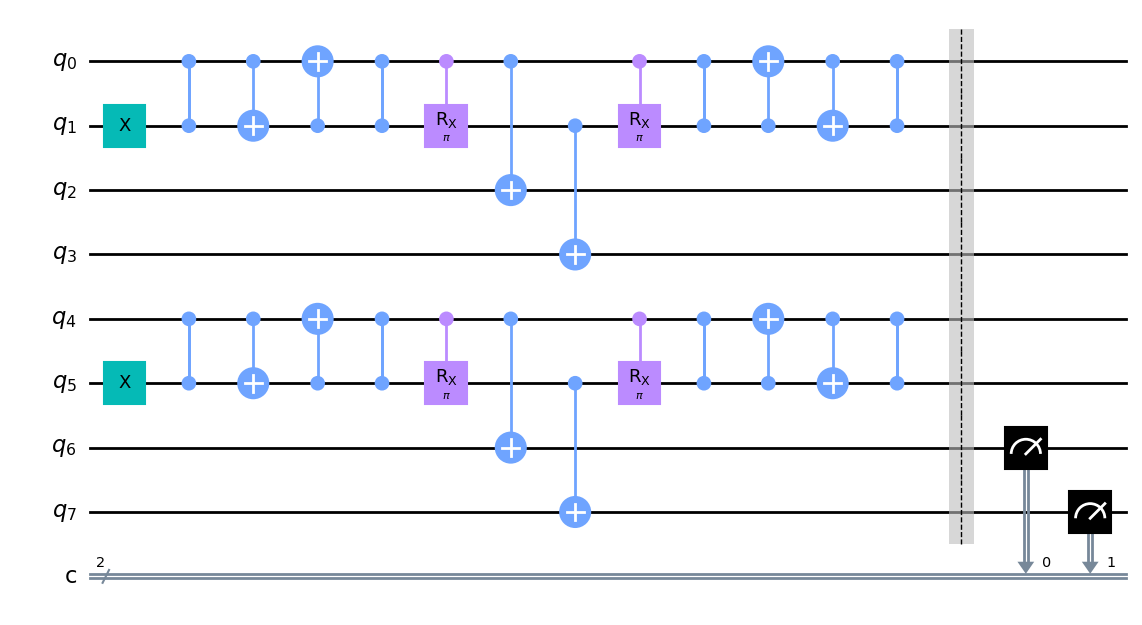

In [89]:
#measurement test circuit to see if the interferometer works as intended
measTest = QuantumCircuit(8, 2) #8 qubits, and 4 classical bits to record outcome
measTest.barrier(range(8)) #just draws a barrier on the circuit

measTest.measure([6, 7], range(2)) #add the two measurements, just gonna check the bottom one bc the two are identical

#smooshing together the acutal circuit and the measurements on the end
qcTest = measTest.compose(circuit, range(8), front=True)

qcTest.draw('mpl')

In [ ]:
#making a new circuit for the cost function that we'll measure
measPartial = QuantumCircuit(8, 2) #8 qubits, and 4 classical bits to record outcome
measPartial.barrier(range(8)) #just draws a barrier on the circuit
measPartial.cx(2, 6)
measPartial.cx(3, 7)

measPartial.measure([6, 7], range(2)) #add the two measurements

#smooshing together the acutal circuit and the measurements on the end
qcPartial = measPartial.compose(circuit, range(8), front=True)

qcPartial.draw('mpl')

In [ ]:
#making a new circuit for the cost function that we'll measure
measFull = QuantumCircuit(8, 4) #8 qubits, and 4 classical bits to record outcome
measFull.barrier(range(8)) #just draws a barrier on the circuit
measFull.cx(2, 6)
measFull.cx(3, 7)
measFull.h([2, 3])
#the hadamards are to calculate full cost

measFull.measure([2, 3, 6, 7], range(4)) #add the four measurements

#smooshing together the acutal circuit and the measurements on the end
qcFull = measFull.compose(circuit, range(8), front=True)

qcFull.draw('mpl')

In [8]:
#bind the phi parameter

#we don't actually need this step out here, will be binding parameters during each optimization step

phi_2_range = np.linspace(-3, 3, 32)
theta_2_range = np.linspace(0, np.pi, 32)
angle_range = list(itertools.product(phi_2_range, theta_2_range))

full_circuits = [qcFull.assign_parameters({phi_2: phi_2_val, theta_2: theta_2_val})
            for (phi_2_val, theta_2_val) in angle_range]

partial_circuits = [qcPartial.assign_parameters({phi_2: phi_2_val, theta_2: theta_2_val})
            for (phi_2_val, theta_2_val) in angle_range]

In [19]:
# compile the circuit down to low-level QASM instructions
# supported by the backend (not needed for simple circuits)
compiled_circuit_partial = transpile(qcPartial, simulator)

# Execute the circuit on the qasm simulator
job_partial = simulator.run(compiled_circuit_partial, shots=1024)

# Grab results from the job
result_partial = job_partial.result()

# Returns counts
counts_partial = result_partial.get_counts()
#print("\nTotal counts are:",counts_partial[0])
#print(len(counts_partial))

# compile the circuit down to low-level QASM instructions
# supported by the backend (not needed for simple circuits)
compiled_circuit_full = transpile(qcFull, simulator)

# Execute the circuit on the qasm simulator
job_full = simulator.run(compiled_circuit_full, shots=1024)

# Grab results from the job
result_full = job_full.result()

# Returns counts
counts_full = result_full.get_counts()
print("\nTotal counts are:",counts_partial)


Total counts are: {'01': 251, '10': 252, '11': 260, '00': 261}


In [90]:
# compile the circuit down to low-level QASM instructions - test circuit
# supported by the backend (not needed for simple circuits)
compiled_circuit_test = transpile(qcTest, simulator)

# Execute the circuit on the qasm simulator
job_test = simulator.run(compiled_circuit_test, shots=1024)

# Grab results from the job
result_test = job_test.result()

# Returns counts
counts_test = result_test.get_counts()
print("\nTotal counts are:",counts_test)
#print("\n0's percentage:",counts_test['0']/1024)
#print(len(counts_test))




Total counts are: {'01': 1024}


In [20]:
fails = {'0101', '0111', '1010', '1011', '1101', '1110'}
shots = 1024
cost_matrix = np.zeros(32**2)

#this needs to update, this now needs to be run for each element in counts_full and counts_partial which are each lists of count dictionaries
#TODO: update to run over all values of phi_1, then both phi_1 and phi_2

def compute_cost(full_counts, partial_counts):
    p_full = 0
    overlap_partial = 0
    for i in fails:
        if i in full_counts:
            p_full += full_counts[i]
    overlap_full = 1-2*(p_full/shots)
    overlap_partial = partial_counts['00']/shots
    return overlap_full-overlap_partial

#for i in range(32**2):
    #cost_matrix[i] = compute_cost(counts_full[i], counts_partial[i])

#print(p_full)
#print(overlap_full)
#print(overlap_partial)
#print(cost_matrix)

0.2587890625


In [11]:
cost_matrix = np.reshape(cost_matrix, (32, 32))
cost_matrix = np.rot90(cost_matrix)


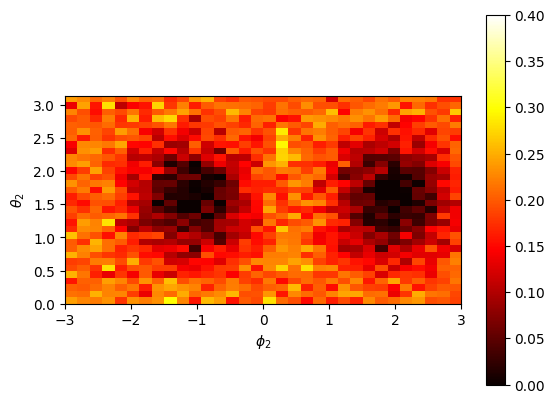

In [13]:
plt.imshow(cost_matrix, cmap='hot', interpolation='none', extent=[-3, 3, 0, math.pi], vmin=0, vmax=0.4)
plt.xlabel('$\phi_2$')
plt.ylabel('$\\theta_2$')
plt.colorbar()
plt.show() 

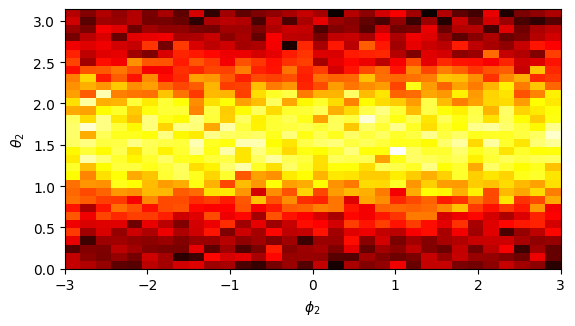

In [26]:
plt.imshow(cost_matrix, cmap='hot', interpolation='none', extent=[-3, 3, 0, math.pi])
plt.xlabel('$\phi_2$')
plt.ylabel('$\\theta_2$')
plt.show() #start in -z

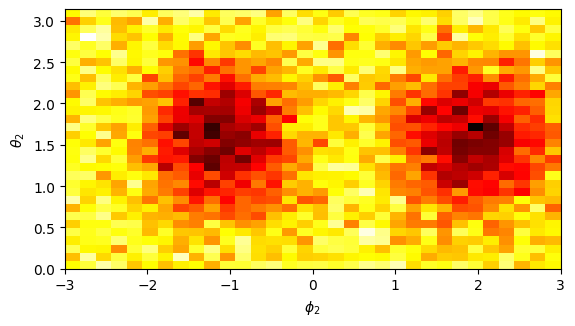

In [44]:
plt.imshow(cost_matrix, cmap='hot', interpolation='none', extent=[-3, 3, 0, math.pi])
plt.xlabel('$\phi_2$')
plt.ylabel('$\\theta_2$')
plt.show() #start in +x

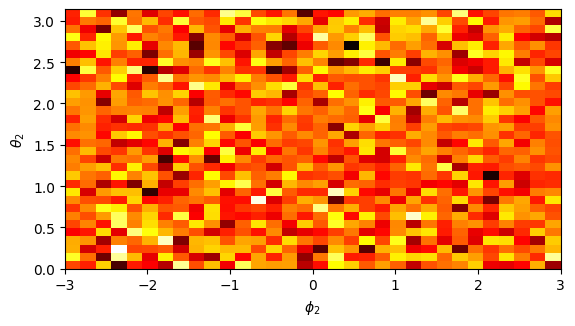

In [52]:
plt.imshow(cost_matrix, cmap='hot', interpolation='none', extent=[-3, 3, 0, math.pi])
plt.xlabel('$\phi_2$')
plt.ylabel('$\\theta_2$')
plt.show() #start in +x, 3 rad time evolve

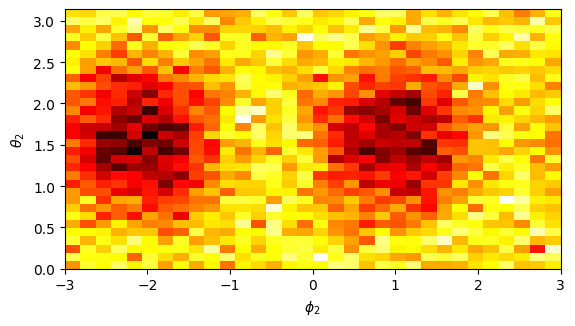

In [60]:
plt.imshow(cost_matrix, cmap='hot', interpolation='none', extent=[-3, 3, 0, math.pi])
plt.xlabel('$\phi_2$')
plt.ylabel('$\\theta_2$')
plt.show() #start in +x, 1 rad time evolve

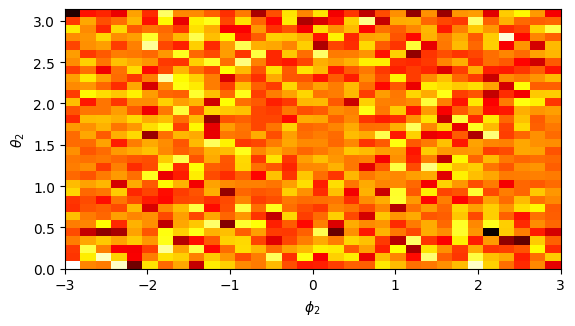

In [76]:
plt.imshow(cost_matrix, cmap='hot', interpolation='none', extent=[-3, 3, 0, math.pi])
plt.xlabel('$\phi_2$')
plt.ylabel('$\\theta_2$')
plt.show() #start in +x, 0 rad time evolve

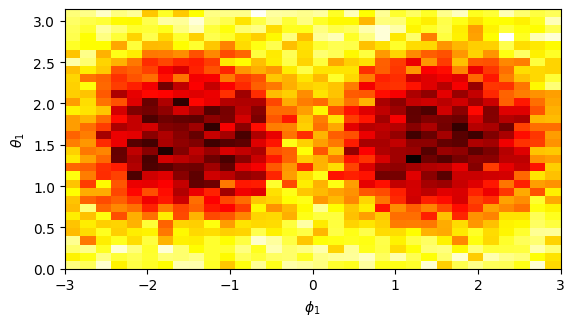

In [85]:
plt.imshow(cost_matrix, cmap='hot', interpolation='none', extent=[-3, 3, 0, math.pi])
plt.xlabel('$\phi_1$')
plt.ylabel('$\\theta_1$')
plt.show() #start in +x, var middle proj, end in +x (?)